#Setup for Orb and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Maestria/Trimestres/Trimestre 6 Apr-Jun2025/PI"
os.chdir(DATA_PATH)

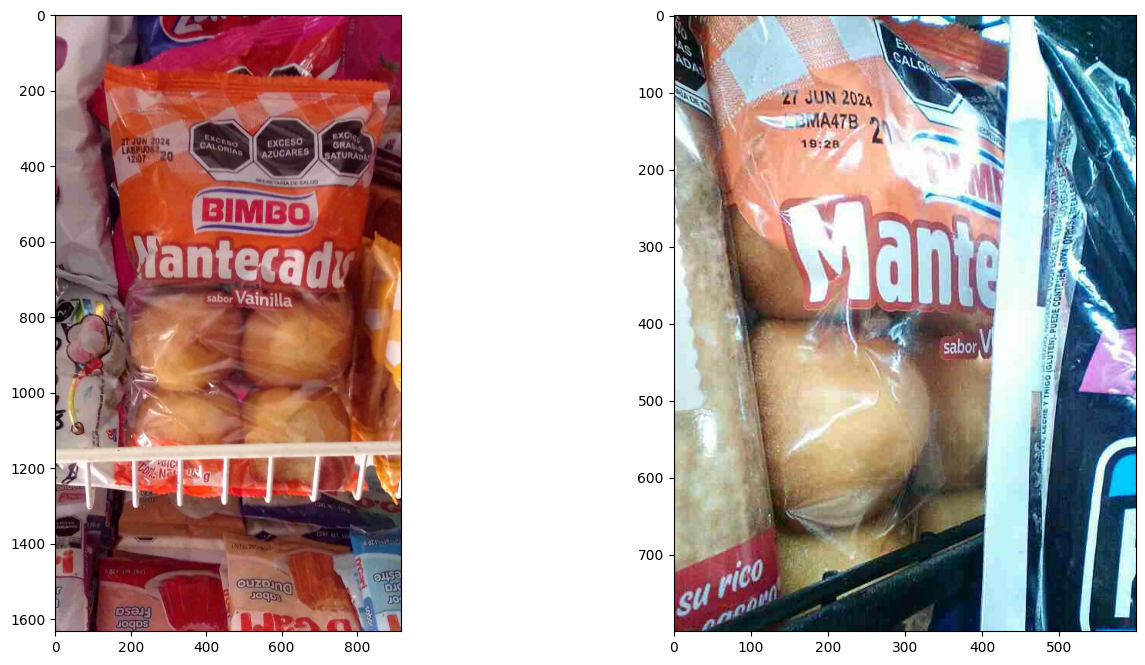

In [ ]:
# read images
imgs_path = 'output_image_analysis_bimbo/potentially_good_images'
images = [t for t in os.listdir(imgs_path) if os.path.isfile(os.path.join(imgs_path, t))]
img1_file = random.choice(images)
img1 = os.path.join(imgs_path, img1_file)
img1 = cv2.imread(img1)
img2_file = random.choice(images)
img2 = os.path.join(imgs_path, img2_file)
img2 = cv2.imread(img2)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

figure, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img1)
ax[1].imshow(img2)

In [ ]:
#ORB
orb = cv2.ORB_create()

kp_orb1, des_orb1 = orb.detectAndCompute(img1,None)
kp_orb2, des_orb2 = orb.detectAndCompute(img2,None)

len(kp_orb1), len(kp_orb2)

(500, 500)

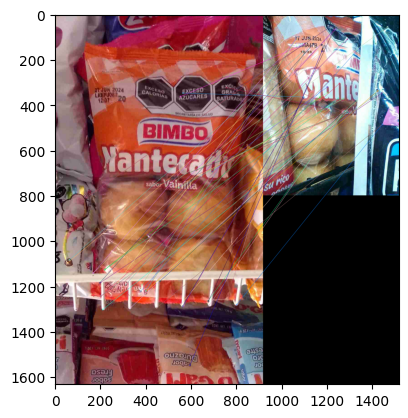

143

In [ ]:
#feature matching
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf_orb.match(des_orb1, des_orb2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, kp_orb1, img2, kp_orb2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

len(matches)

#SAM automatic mask generator

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class SamAutomaticMaskGenerator implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-mkvqbenw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-mkvqbenw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5d523e679443a5162399d28fab66bdaf76f2a6c6bdd56b3d79078001c704dbf6
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bkubwrh/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-06-11 23:01:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.84, 13.

To run automatic mask generation, provide a SAM model to the SamAutomaticMaskGenerator class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def show_anns(anns, flag=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=flag)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
#image to get masks from
image = cv2.imread('data/modelosBimbo.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#show image
plt.figure(figsize=(12,6))
plt.imshow(image)
plt.axis('off')
plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
masks = mask_generator.generate(img1)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

* segmentation : the mask
* area : the area of the mask in pixels
* bbox : the boundary box of the mask in XYWH format
* predicted_iou : the model's own prediction for the quality of the mask
* point_coords : the sampled input point that generated this mask
* stability_score : an additional measure of mask quality
* crop_box : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

59
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


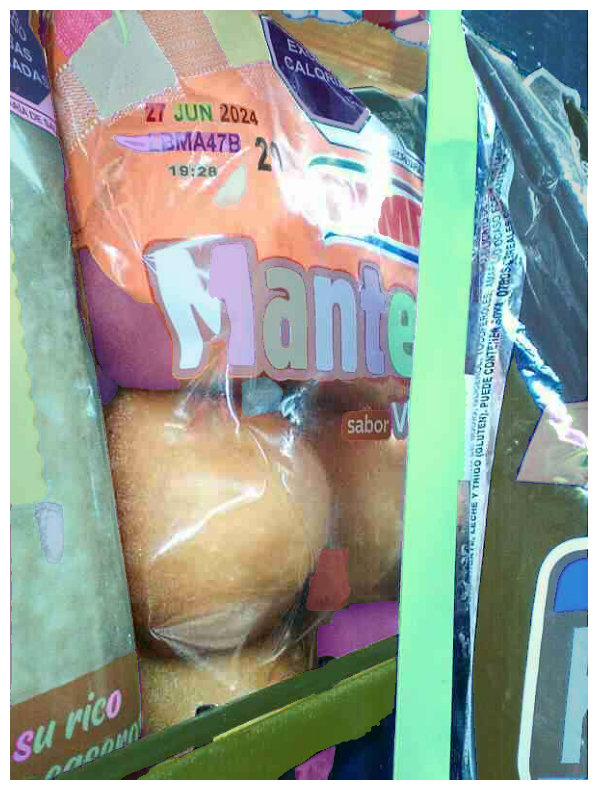

In [ ]:
# show the overlayed masks on image
plt.figure(figsize=(10,10))
plt.imshow(img2)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8,
    pred_iou_thresh=0.84,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1250,  # Requires open-cv to run post-processing
)

In [ ]:
masks = mask_generator_2.generate(img2)

In [ ]:
print(len(masks))
print(masks[0].keys())

36
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


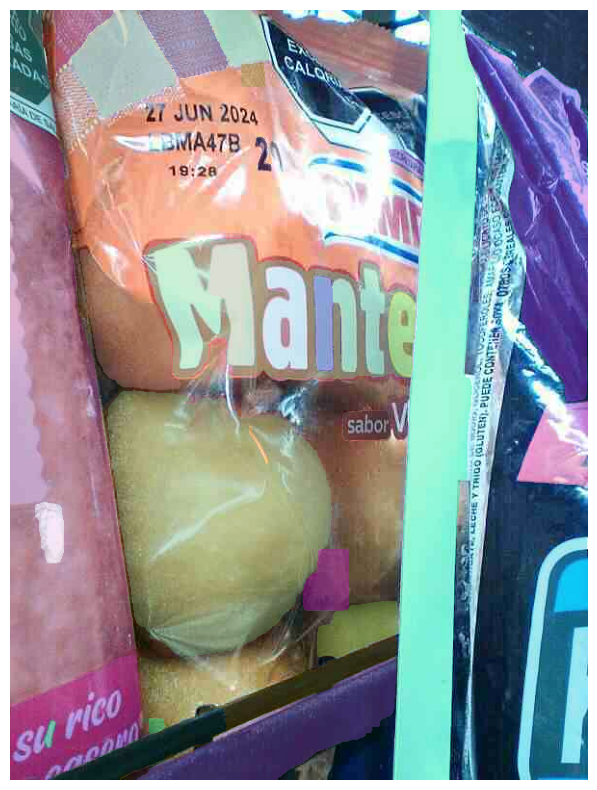

In [ ]:
# show the overlayed masks on image
plt.figure(figsize=(10,10))
plt.imshow(img2)
show_anns(masks)
plt.axis('off')
plt.show()

Filter masks with orb features to segment a specific product

In [ ]:
def filter_masks_by_orb_matches(kp, matches, masks, min_matches=1):

    # Extraer coordenadas de keypoints que hicieron match
    matched_pts = [kp[m.queryIdx].pt for m in matches]
    matched_pts = np.round(matched_pts).astype(int)# (x, y) -> píxeles

    filtered = []
    for mask_dict in masks:
        mask = mask_dict["segmentation"]
        count = sum(1 for (x, y) in matched_pts if 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[y, x])
        if count >= min_matches:
            filtered.append(mask_dict)

    return filtered

In [ ]:
#in this case we want larger masks to be on top so
full_masks = sorted(masks, key=(lambda x: x['area']))
filtered_masks = filter_masks_by_orb_matches(kp_orb2, matches, full_masks, 20)
len(filtered_masks)

1

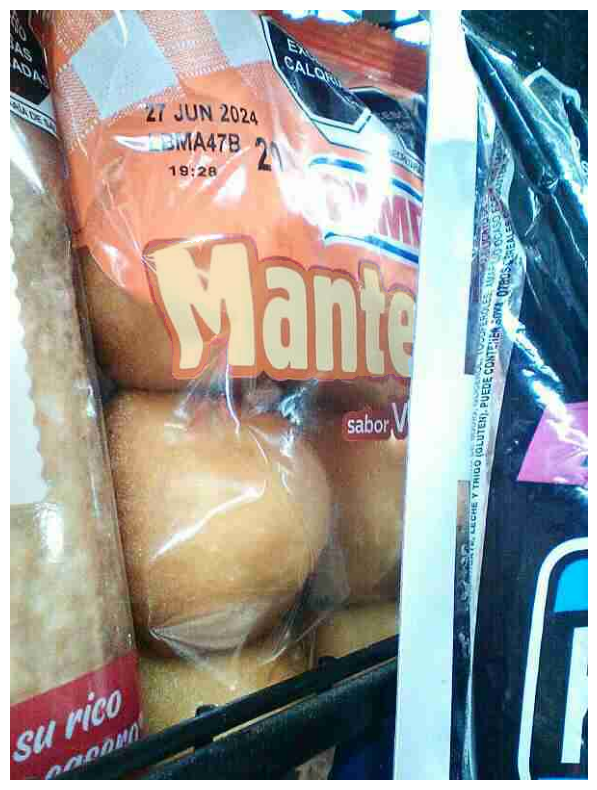

In [ ]:
# show the overlayed masks on image
plt.figure(figsize=(10,10))
plt.imshow(img2)
show_anns(filtered_masks, False)
plt.axis('off')
plt.show()

#SAM Predict with orb features

In [ ]:
os.chdir('../../../../../../..')

In [ ]:
from segment_anything import build_sam, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [ ]:
from scipy.ndimage import gaussian_filter

def get_high_density_match_point(kp, matches, image_shape, sigma=10):
    """
    Calcula el punto con mayor concentración de matches ORB.

    Args:
        kp (list): Keypoints de la imagen base.
        matches (list): Lista de matches de ORB.
        image_shape (tuple): (H, W) de la imagen.
        sigma (int): Desviación para suavizar la densidad (tipo kernel Gaussiano).

    Returns:
        (x, y): Coordenadas del punto más denso.
    """
    h, w = image_shape[:2]
    heatmap = np.zeros((h, w), dtype=np.float32)

    # Acumular puntos coincidentes
    for m in matches:
        x, y = kp[m.queryIdx].pt
        x, y = int(round(x)), int(round(y))
        if 0 <= x < w and 0 <= y < h:
            heatmap[y, x] += 1

    # Suavizar la densidad con un filtro Gaussiano
    density = gaussian_filter(heatmap, sigma=sigma)

    # Encontrar el punto de máxima densidad
    y_peak, x_peak = np.unravel_index(np.argmax(density), density.shape)
    return (x_peak, y_peak), density

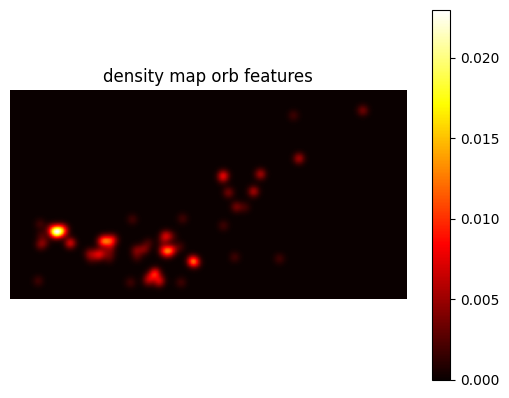

In [ ]:
point, density_map = get_high_density_match_point(kp_orb2, matches, img2.shape)

# Visualizar del mapa de calor
plt.imshow(density_map, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("density map orb features")
plt.axis('off')
plt.show()

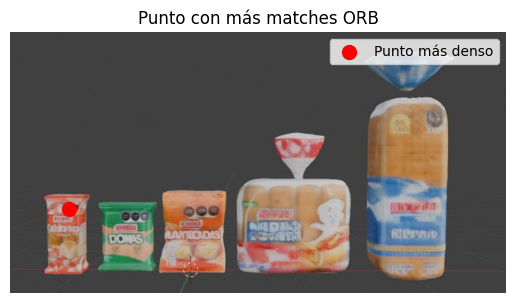

In [ ]:
# Visualizar el punto con mayor densidad de features
plt.imshow(img2)
plt.scatter(*point, c='red', s=100, label="Punto más denso")
plt.title("Punto con más matches ORB")
plt.legend()
plt.axis('off')
plt.show()

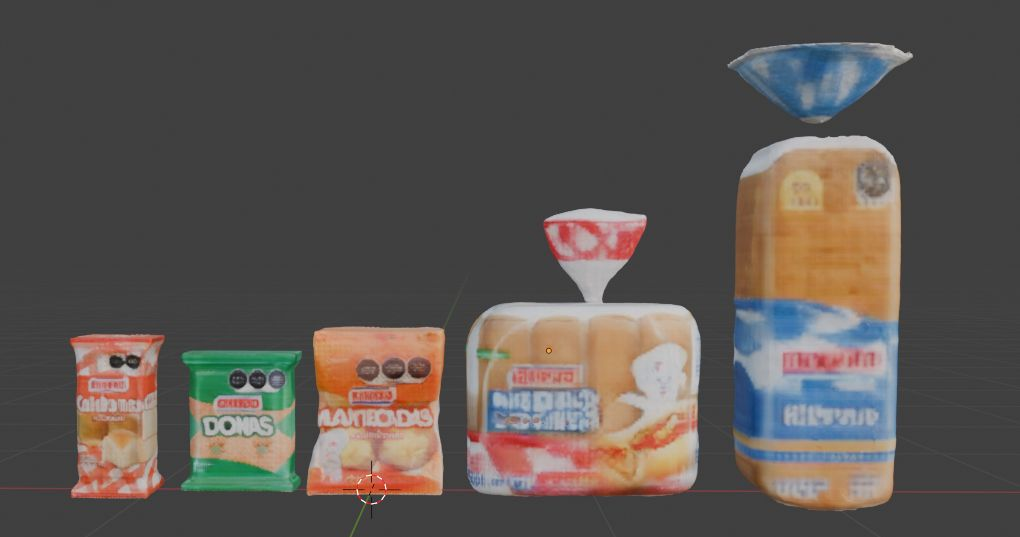

In [ ]:
from PIL import Image

image = Image.open(DATA_PATH + '/data/modelosBimbo.jpg')
image = np.asarray(image)

point_coords_np = np.array([[point]])  # convierte a np.ndarray si no lo es
point_coords = torch.from_numpy(point_coords_np).to(sam_predictor.device)  # mucho más eficiente


input_label = np.array([[1]])
point_labels = torch.from_numpy(input_label).to(sam_predictor.device)

Image.fromarray(image)

In [ ]:
#set image
sam_predictor.set_image(image)

In [ ]:
# Segmentacion por punto
masks, _, _ = sam_predictor.predict_torch(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output = False,
        )

In [ ]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    # move mask to cpu before convert it to numpy array
    mask = mask.cpu().numpy()
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [ ]:
masks[0][0].shape[-2:]

torch.Size([537, 1020])

In [ ]:
annotated_frame_with_mask = show_mask(masks[0][0], image)

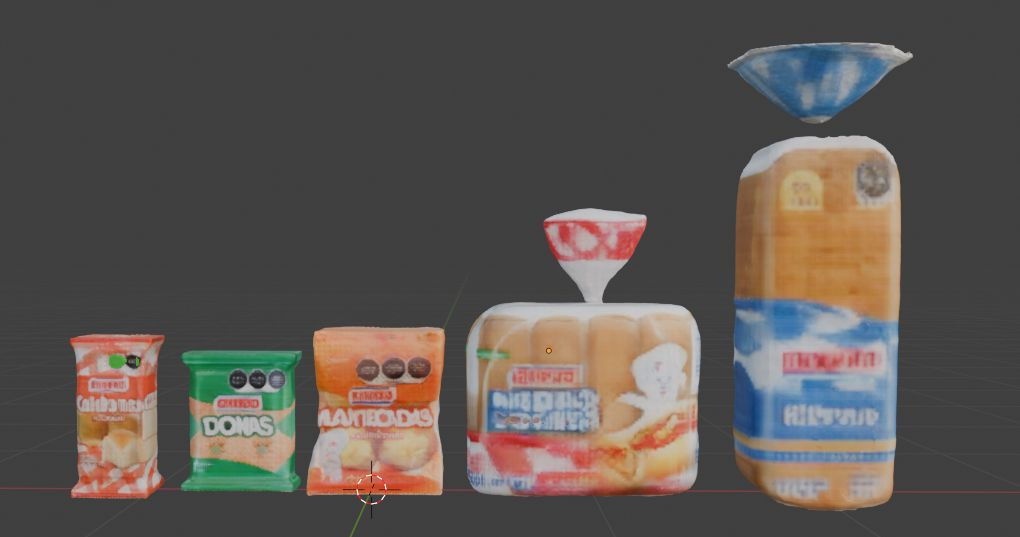

In [ ]:
Image.fromarray(annotated_frame_with_mask)